In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from gluonts.dataset.split import split
from gluonts.dataset.common import (
    MetaData,
    TrainDatasets,
    FileDataset,
)
plt.style.use('seaborn')

/tmp/ipykernel_43203/3732702600.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
def get_custom_dataset(
    jsonl_path: Path,
    freq: str,
    prediction_length: int,
    split_offset: int = None,
):
    """Creates a custom GluonTS dataset from a JSONLines file and
    give parameters.

    Parameters
    ----------
    jsonl_path
        Path to a JSONLines file with time series
    freq
        Frequency in pandas format
        (e.g., `H` for hourly, `D` for daily)
    prediction_length
        Prediction length
    split_offset, optional
        Offset to split data into train and test sets, by default None

    Returns
    -------
        A gluonts dataset
    """
    if split_offset is None:
        split_offset = -prediction_length

    metadata = MetaData(freq=freq, prediction_length=prediction_length)
    test_ts = FileDataset(jsonl_path, freq)
    train_ts, _ = split(test_ts, offset=split_offset)
    dataset = TrainDatasets(metadata=metadata, train=train_ts, test=test_ts)
    return dataset

In [4]:
dataset = get_custom_dataset('datasets/^gspc_dataset.jsonl', freq='D', prediction_length=30)

In [5]:
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

# Initialize the DeepAR estimator
deepar_estimator = DeepAREstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=200,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
deepar_predictor = deepar_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:07<00:00, 12.75it/s, epoch=200/200, avg_epoch_loss=-4.82]


In [6]:
from gluonts.mx.model.transformer import TransformerEstimator

# Initialize the Transformer estimator
transformer_estimator = TransformerEstimator(
    freq="D",
    prediction_length=30,
    trainer=Trainer(
        epochs=200,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

# Train the model
transformer_predictor = transformer_estimator.train(training_data=dataset.train)


100%|██████████| 100/100 [00:05<00:00, 17.11it/s, epoch=200/200, avg_epoch_loss=-4.29]


In [7]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

def evaluate_model(predictor, test_data):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(tss, forecasts, num_series=len(test_data))

    for i, (ts_entry, forecast_entry) in enumerate(zip(tss, forecasts)):
        # Plot and save each time series and forecast comparison
        plt.figure(figsize=(10, 5))
        plt.plot(ts_entry[-150:].to_timestamp(), label='Actual')  # Adjust the slicing according to your data
        forecast_entry.plot(color='crimson', label='Forecast')
        plt.legend()
        plt.title(f'Forecast vs Actuals for Series {i}')
        # plt.savefig(os.path.join(output_dir, f'forecast_plot_{i}.png'))  # Save the plot as a PNG file
        plt.plot()

    return agg_metrics, item_metrics


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


DeepAR Evaluation Metrics: {'MSE': 5.2876040960351627e-05, 'abs_error': 0.1758221536874771, 'abs_target_sum': 0.12265690416097641, 'abs_target_mean': 0.004088563472032547, 'seasonal_error': 0.012244074152073793, 'MASE': 0.478659176958398, 'MAPE': 2.9870330810546877, 'sMAPE': 1.6047527313232421, 'MSIS': 11.02526458748134, 'QuantileLoss[0.1]': 0.13201828121673317, 'Coverage[0.1]': 0.3333333333333333, 'QuantileLoss[0.2]': 0.15205902196466925, 'Coverage[0.2]': 0.43333333333333335, 'QuantileLoss[0.3]': 0.16501943373586983, 'Coverage[0.3]': 0.4666666666666667, 'QuantileLoss[0.4]': 0.17346735305618496, 'Coverage[0.4]': 0.4666666666666667, 'QuantileLoss[0.5]': 0.17582215671427548, 'Coverage[0.5]': 0.4666666666666667, 'QuantileLoss[0.6]': 0.17267308346927165, 'Coverage[0.6]': 0.4666666666666667, 'QuantileLoss[0.7]': 0.16715203118510544, 'Coverage[0.7]': 0.5333333333333333, 'QuantileLoss[0.8]': 0.1582400635816157, 'Coverage[0.8]': 0.5333333333333333, 'QuantileLoss[0.9]': 0.13628904895158483, 'Co

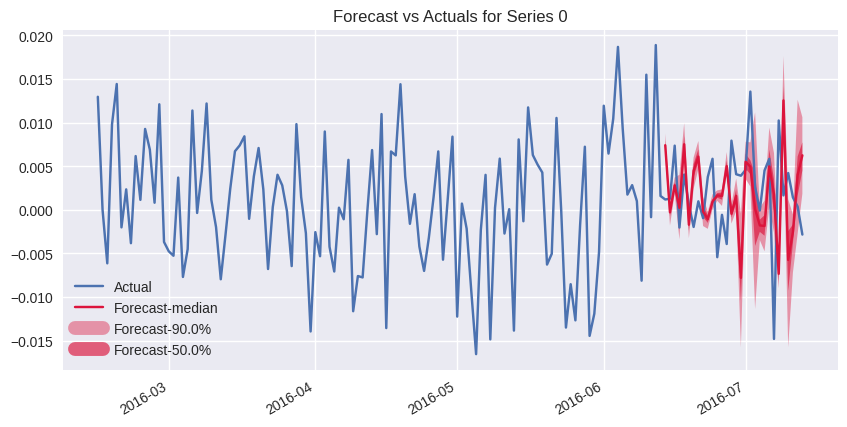

In [8]:
deepar_metrics, _ = evaluate_model(deepar_predictor, dataset.test)
print("DeepAR Evaluation Metrics:", deepar_metrics)


Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


Transformer Evaluation Metrics: {'MSE': 4.0903008387734495e-05, 'abs_error': 0.1461659073829651, 'abs_target_sum': 0.12265690416097641, 'abs_target_mean': 0.004088563472032547, 'seasonal_error': 0.012244074152073793, 'MASE': 0.3979228524959801, 'MAPE': 3.5565172831217446, 'sMAPE': 1.263364028930664, 'MSIS': 3.8406477537845016, 'QuantileLoss[0.1]': 0.07090691984631123, 'Coverage[0.1]': 0.06666666666666667, 'QuantileLoss[0.2]': 0.10023141726851463, 'Coverage[0.2]': 0.1, 'QuantileLoss[0.3]': 0.11912297664093785, 'Coverage[0.3]': 0.23333333333333334, 'QuantileLoss[0.4]': 0.1366482360986993, 'Coverage[0.4]': 0.3333333333333333, 'QuantileLoss[0.5]': 0.14616591145750135, 'Coverage[0.5]': 0.43333333333333335, 'QuantileLoss[0.6]': 0.14707809952087697, 'Coverage[0.6]': 0.43333333333333335, 'QuantileLoss[0.7]': 0.13519335016608242, 'Coverage[0.7]': 0.5333333333333333, 'QuantileLoss[0.8]': 0.11918044653721153, 'Coverage[0.8]': 0.6, 'QuantileLoss[0.9]': 0.08445815222803504, 'Coverage[0.9]': 0.7, 'R

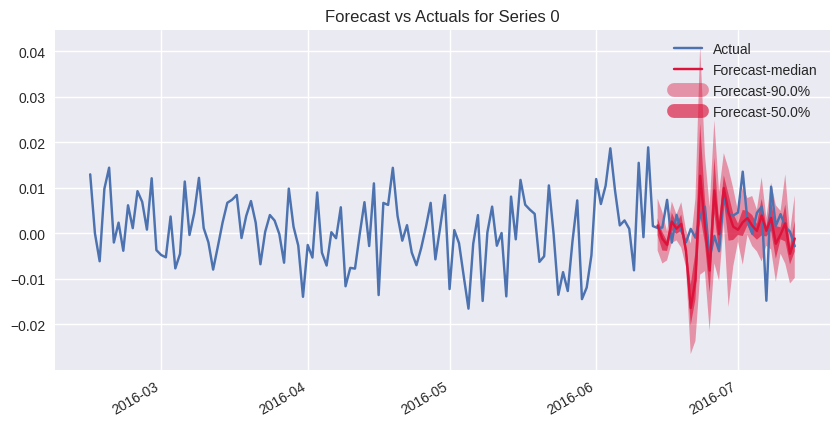

In [9]:
transformer_metrics, _ = evaluate_model(transformer_predictor, dataset.test)
print("Transformer Evaluation Metrics:", transformer_metrics)
